# Réseaux de neurones convolutifs (CNN)

Dans ce notebook, on utilise des **réseaux convolutifs** (ou CNN, Convolutional Neural Network). 

Ce type de réseau de neurones est généralement utilisé pour analyser les images et est constitué d'une ou plusieurs couches convolutives, suivies d'une ou plusieurs couches linéaires. Les couches convolutives utilisent des filtres qui balaient une image et produisent une version traitée de l'image. Cette version traitée de l'image peut être introduite dans une autre couche convolutionnelle ou une couche linéaire. Chaque filtre a une forme, par exemple un filtre 3x3 couvre une zone de 3 pixels de large et 3 pixels de haut de l'image, et chaque élément du filtre a un poids qui lui est associé, le filtre 3x3 aurait 9 poids.
Les couches convolutives agissent alors comme des extracteurs de caractéristiques, extrayant les parties de l'image les plus importantes. 

Les réseaux de neurones convolutifs ont été introduit plus récemment pour le traitement du langage.
En effet, de la même manière qu'un filtre 3x3 peut être appliqué sur une zone d'une image, un filtre 1x2 peut être appliqué sur 2 mots séquentiels dans un bout de texte, c'est-à-dire un bi-gramme.

L'intuition ici est que l'apparition de certains bi-grammes, tri-grammes et n-grammes dans la revue sera une bonne indication du sentiment final.

## Préparer les données

Comme les couches convolutionnelles s'attendent à ce que la dimension du batch soit la première, nous pouvons dire à TorchText de renvoyer les données déjà permutées en utilisant l'argument batch_first = True dans la méthode `Field`.


In [1]:
import pandas as pd
import torch
from torchtext import data
from torchtext import datasets
import random
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

test_data, valid_data = test_data.split(random_state = random.seed(1234))


print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


## Itérateurs

In [2]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device, sort = False)

## Construire le modèle

Le texte est en 1 dimension. Cependant, nous savons que la première étape de presque tous nos notebooks précédents consiste à convertir les mots en représentation numérique (avec la méthode GloVe). C'est ainsi que nous pouvons visualiser nos mots en 2 dimensions, chaque mot le long d'un axe et les éléments de vecteurs sur l'autre dimension.
On peut alors utiliser un filtre qui est **[n x emb_dim]**. Cela couvrira entièrement les mots séquentiels $n$, car leur largeur sera de dimension emb_dim.

La prochaine étape de notre modèle consiste à utiliser le pooling (en particulier le pooling max) sur la sortie des couches convolutives afin de prendre la valeur maximale sur une dimension.

 - Nous implémentons les couches convolutives avec `nn.Conv2d`. L'argument in_channels est le nombre de "channels" nous n'avons qu'un seul "channel", le texte lui-même. Le out_channels est le nombre de filtres et le kernel_size est la taille des filtres. Chacun de nos kernel_sizes va être [n x emb_dim] où $n$ est la taille des n-grammes.
 
 - En PyTorch, les RNN veulent l'entrée avec la dimension batch en second, tandis que les CNN veulent d'abord la dimension batch - nous n'avons pas besoin de permuter les données ici car nous avons déjà défini `batch_first = True` dans notre champ `TEXT`.
 
 - Nous passons ensuite les tenseurs à travers les couches convolutives et de pooling, en utilisant la fonction d'activation `ReLU` après les couches convolutives. La taille de la sortie de la couche convolutive dépend de la taille de l'entrée, et différents lots contiennent des phrases de différentes longueurs.
 
 - Enfin, nous effectuons des dropouts sur les sorties de filtre concaténées, puis nous les faisons passer à travers une couche fully connected pour faire nos prédictions.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)  
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)  
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):           
        
        embedded = self.dropout(self.embedding(text)) 
        embedded = embedded.unsqueeze(1) 
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved] 
        cat = self.dropout(torch.cat(pooled, dim = 1))
            
        return self.fc(cat)
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 50
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = 1
DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 5,045,501 paramètres à entraîner


In [4]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [5]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):
    """
    Retourne l'accuracy
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


In [6]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()  
        predictions = model(batch.text).squeeze(1)  
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()    
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 50

best_valid_loss = float('inf')
tloss = []
tacc = []
vloss = []
vacc = []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)   
    tloss.append(train_loss)
    tacc.append(train_acc)   
    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)    

    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    if epoch%10 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 4s
	Train Loss: 0.791 | Train Acc: 50.18%
	 Val. Loss: 0.693 |  Val. Acc: 50.76%
Epoch: 11 | Epoch Time: 1m 0s
	Train Loss: 0.703 | Train Acc: 53.01%
	 Val. Loss: 0.689 |  Val. Acc: 51.38%
Epoch: 21 | Epoch Time: 1m 0s
	Train Loss: 0.524 | Train Acc: 74.54%
	 Val. Loss: 0.505 |  Val. Acc: 76.59%
Epoch: 31 | Epoch Time: 1m 0s
	Train Loss: 0.408 | Train Acc: 82.61%
	 Val. Loss: 0.437 |  Val. Acc: 81.72%
Epoch: 41 | Epoch Time: 1m 0s
	Train Loss: 0.344 | Train Acc: 85.89%
	 Val. Loss: 0.422 |  Val. Acc: 81.66%


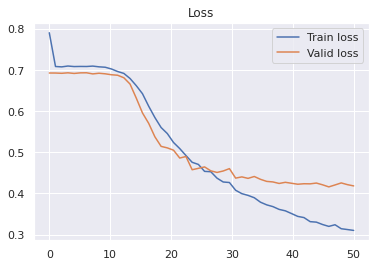

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])


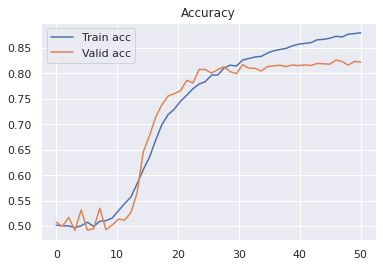

In [8]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

In [9]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.416 | Test Acc: 82.17%


In [10]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))

    if (prediction.item() > 0.5):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")


In [11]:
predict_sentiment(model, "this film is not good")

Sentiment: Negative


In [12]:
predict_sentiment(model, "This film is terrible")

Sentiment: Negative


In [13]:
predict_sentiment(model, "This film is great amazing good ")

Sentiment: Positive


## Références :

 - https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
 - https://arxiv.org/pdf/1408.5882.pdf